# Importations

In [1]:
import numpy as np
from scipy.io import loadmat, savemat
from scipy.optimize import curve_fit #, minimize, least_squares
# from scipy.integrate import trapezoid
# from tqdm import tqdm
# from scipy.optimize import fsolve
import seaborn as sns

In [2]:
from StochasticForceInference.StochasticForceInference import *
from StochasticForceInference.fun_SFI import Compute_diffusion
# Get the SFI package on Maxime's Github (eXpensia). 

In [3]:
import ComputeObservables as co
# Personnal .py with functions used to compute observables (PDF, forces, etc.). 
# Copy past the .py in site-packages or in the same floder as the notebook.

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=1)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=200)

# Load the data

In [421]:
directory = '../../analysis_PS_GNP_janus/data/20240909_PS_fps100_without_vids_MCL/7/traj_rp_1p4649_np_1p5875_vid_7.mat'
# directory = '../../analysis_glass/traj_C4_new/TRAJ_C4_fit_result_rigid_08122021rp_1p5185_np_1p5819.mat'
filename = directory[directory.rfind('/')+1:]

In [422]:
filename

'traj_rp_1p4649_np_1p5875_vid_7.mat'

In [424]:
##########

#####

#

# r = float(filename[filename.find('_rp_')+4:filename.find('_np_')].replace('p','.')) * 1e-6
r = 1.5185e-6
drho = 50
rho_m = 1000
eta_m = 0.001
fps = 100 

print(r)

D0 = 4e-21 / (6 * np.pi * eta_m * r)
print("D0 = {0:.3e} m^2".format(D0))

# 

#####

##########

1.5185e-06
D0 = 1.397e-13 m^2


In [425]:
raw_data = co.open_xyz_mat(directory, upward=False, version='new') #* 0.05799 * 1e-6

In [426]:
raw_data

array([[ 2.85610396e-05,  3.20116499e-05, -1.83195470e-05],
       [ 2.86014762e-05,  3.20381912e-05, -1.83381199e-05],
       [ 2.85943809e-05,  3.20383358e-05, -1.83258565e-05],
       ...,
       [ 1.76567031e-05,  1.61630188e-05, -1.87838863e-05],
       [ 1.76696926e-05,  1.61704837e-05, -1.88084484e-05],
       [ 1.76664739e-05,  1.61734117e-05, -1.88203310e-05]],
      shape=(140130, 3))

In [427]:
# Remove zeros at the end of the trajectory:
try:
    ind = list(raw_data[:,0]).index(0)
    raw_data = raw_data[:ind,:]
except ValueError:
    print('No pb. No zero in raw data.')

No pb. No zero in raw data.


In [428]:
raw_data = raw_data[:,:]

In [429]:
N_tot_frames = len(raw_data[:, 0])
frames = np.arange(N_tot_frames)
time = np.arange(0, np.shape(raw_data)[0]) / fps

In [430]:
# Initialize the save (in a dictionnary)
where_to_save_the_data = "./"
tosave = {}

In [431]:
# Set garde fou to modify and/or compute some data only once.
garde_fou_1 = True
garde_fou_2 = True
garde_fou_3 = True
garde_fou_4 = True

In [432]:
# Save data

tosave['directory'] = directory
tosave['filename'] = filename
tosave["fps"] = fps
# tosave["calib"] = calib

# tosave["date_experiment"] = date
# tosave["date_analysis"] = date_auj

tosave["r"] = r
tosave['eta_m'] = eta_m
tosave['rho_m'] = rho_m
tosave['drho'] = drho
tosave['D0'] = D0

tosave["N_tot_frames"] = N_tot_frames
tosave["frames"] = np.copy(frames)
tosave["time"] = np.copy(time)

# tosave["ratioBC"] = ratioBC

# __Watch the Raw Trajectory__

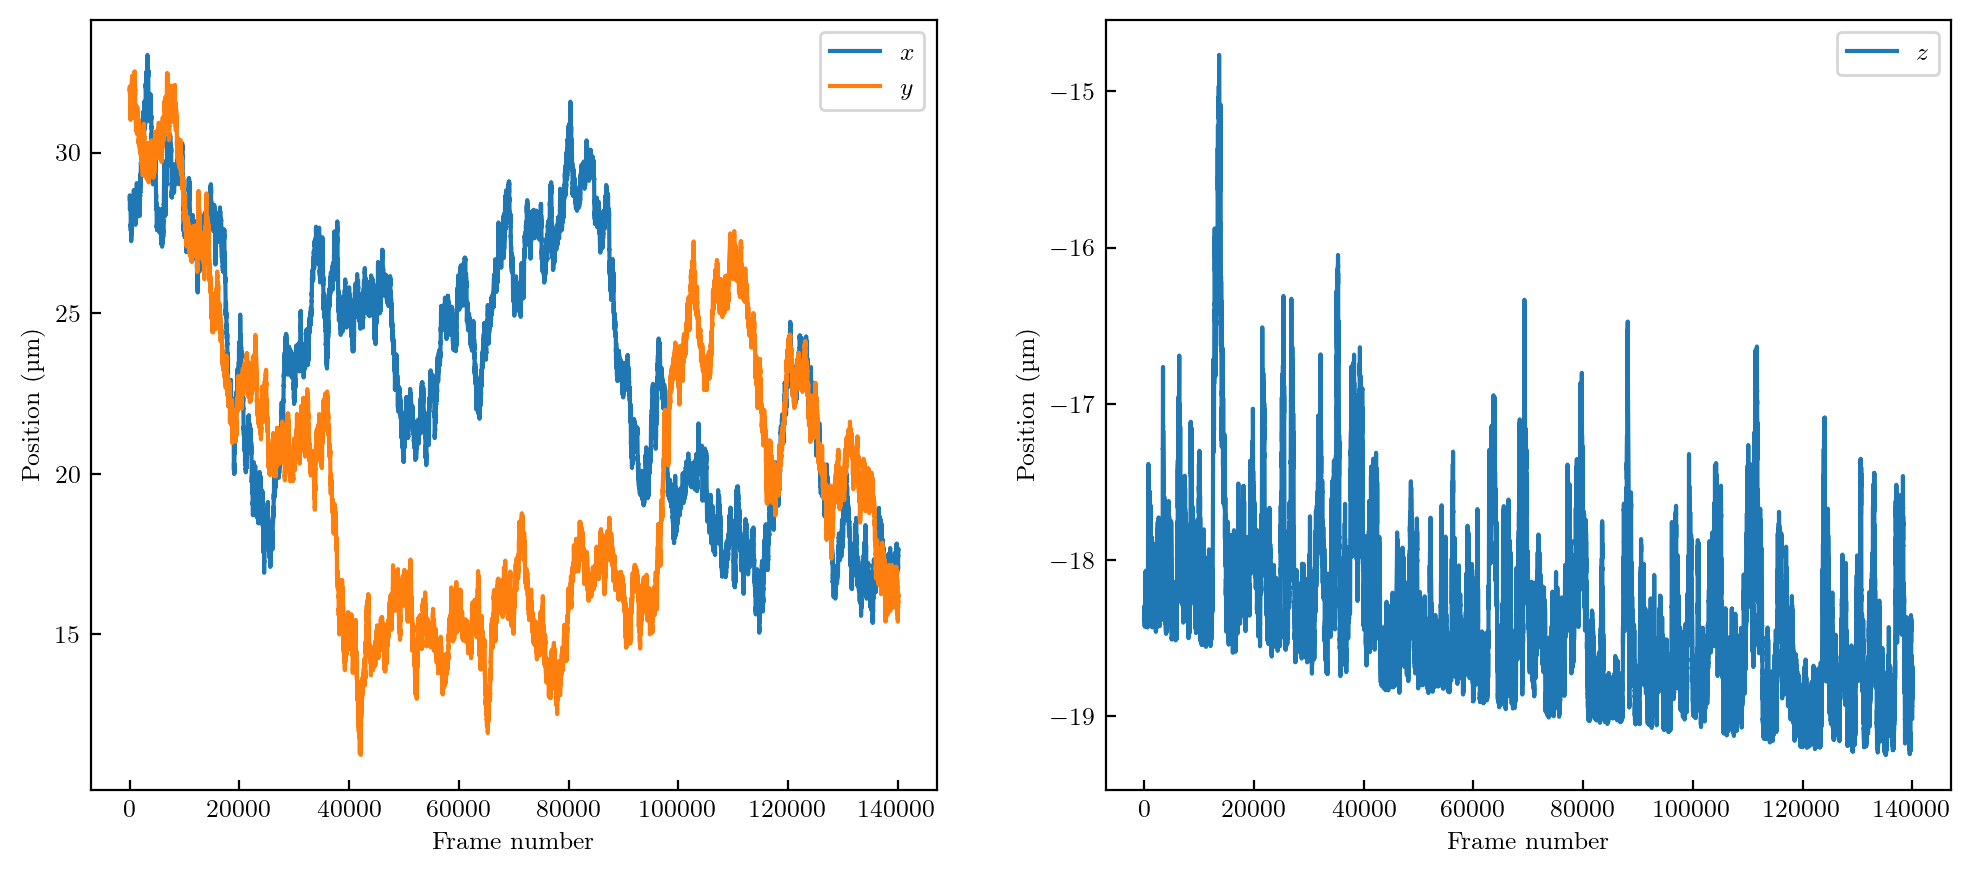

In [433]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axx, axz = axes[0], axes[1]

# fig.canvas.toolbar_visible = True
# fig.canvas.header_visible = True
# fig.canvas.resizable = True

axx.plot(time * fps, raw_data[:, 0] * 1e6, label="$x$")
axx.plot(time * fps, raw_data[:, 1] * 1e6, label="$y$")
axz.plot(time * fps, raw_data[:, 2] * 1e6, label="$z$")

axx.set_xlabel("Frame number")
axx.set_ylabel("Position (µm)")
axz.set_xlabel("Frame number")
axz.set_ylabel("Position (µm)")

axx.legend()
axz.legend()

plt.show() 

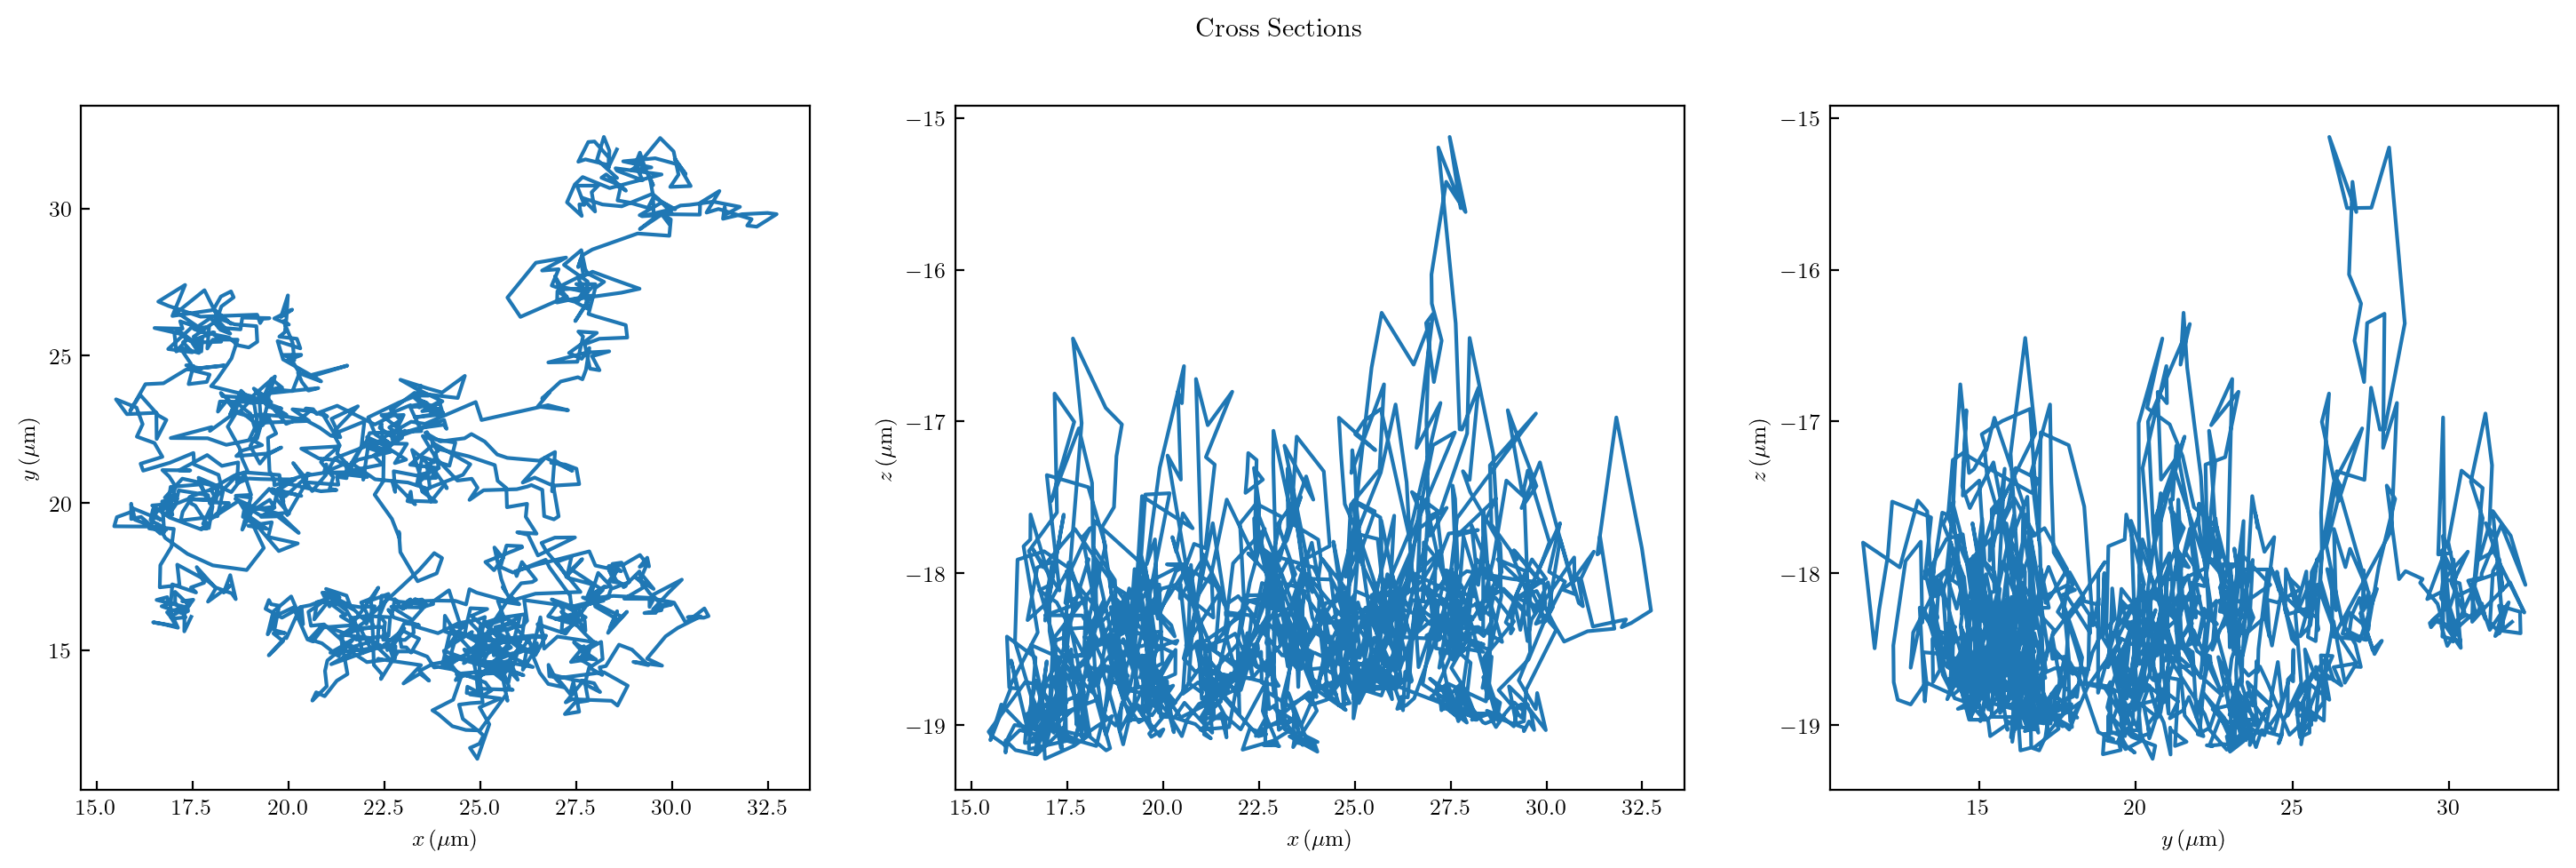

In [434]:
# Profiles of the trajectory

fig, axes = plt.subplots(1, 3, figsize=(18,5))
axxy, axxz, axyz = axes[0], axes[1], axes[2]

axxy.plot(raw_data[::100, 0] * 1e6, raw_data[::100, 1] * 1e6)
axxz.plot(raw_data[::100, 0] * 1e6, raw_data[::100, 2] * 1e6)
axyz.plot(raw_data[::100, 1] * 1e6, raw_data[::100, 2] * 1e6)

axxy.set_xlabel("$x \, \mathrm{(\mu m)}$")
axxy.set_ylabel("$y \, \mathrm{(\mu m)}$")
axxz.set_xlabel("$x \, \mathrm{(\mu m)}$")
axxz.set_ylabel("$z \, \mathrm{(\mu m)}$")
axyz.set_xlabel("$y \, \mathrm{(\mu m)}$")
axyz.set_ylabel("$z \, \mathrm{(\mu m)}$")

fig.suptitle("Cross Sections")

plt.show()

# __Correct Trajectories__

## Add the Corrections to the Sphere's Trajectory

In [435]:
# Use SI

x = raw_data[:, 0]
y = raw_data[:, 1]
z = raw_data[:, 2]

x = x - np.mean(x)
y = y - np.mean(y)
z = z - np.min(z)

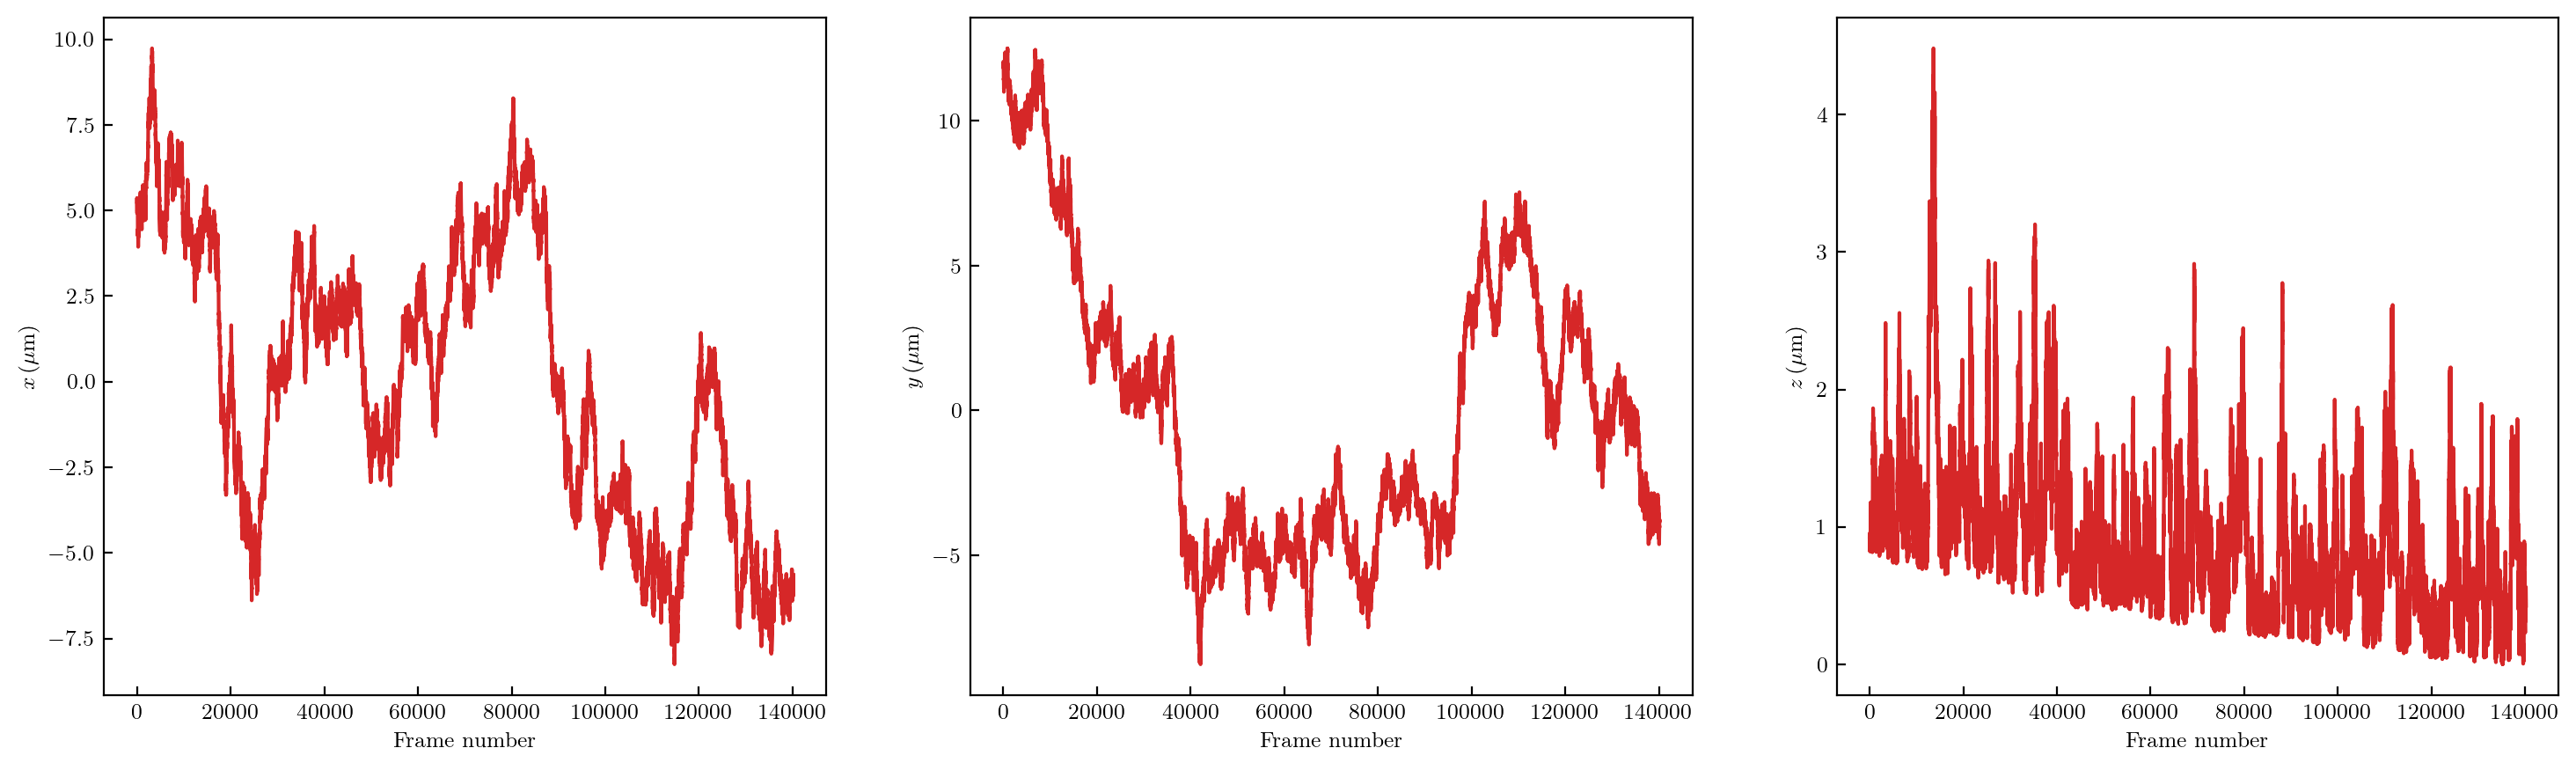

In [436]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
axx, axy, axz = axes[0], axes[1], axes[2]

axx.plot(frames, x * 1e6, ls='-', marker='', markersize=6, c='tab:red')
axy.plot(frames, y * 1e6, ls='-', marker='', markersize=6, c='tab:red')
axz.plot(frames, z * 1e6, ls='-', marker='', markersize=6, c='tab:red')

# axx.legend()
# axz.legend()

axx.set_xlabel("Frame number")
axx.set_ylabel("$x \, \mathrm{(\mu m)}$")
axy.set_xlabel("Frame number")
axy.set_ylabel("$y \, \mathrm{(\mu m)}$")
axz.set_xlabel("Frame number")
axz.set_ylabel("$z \, \mathrm{(\mu m)}$")

plt.show()

## Dedrift the $z$-trajectory

In [437]:
def dedrift(z, n, method='movmin'):
    
    if method == 'movmin':
        return z - co.movmin(z, n)
    else: 
        print('Not coded yet! Just return the input')

Now we use the MSD ($z$) to choose the number of points to use in the dedrifting procedure. 
The choice is 10 times the times required to reach the permanent regime. 

Be careful: the time cannot be too small (loose too much information) and too large (regime of the drift so you don't remove anything).

/tmp/ipykernel_10113/3608097041.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_short, _ = curve_fit(


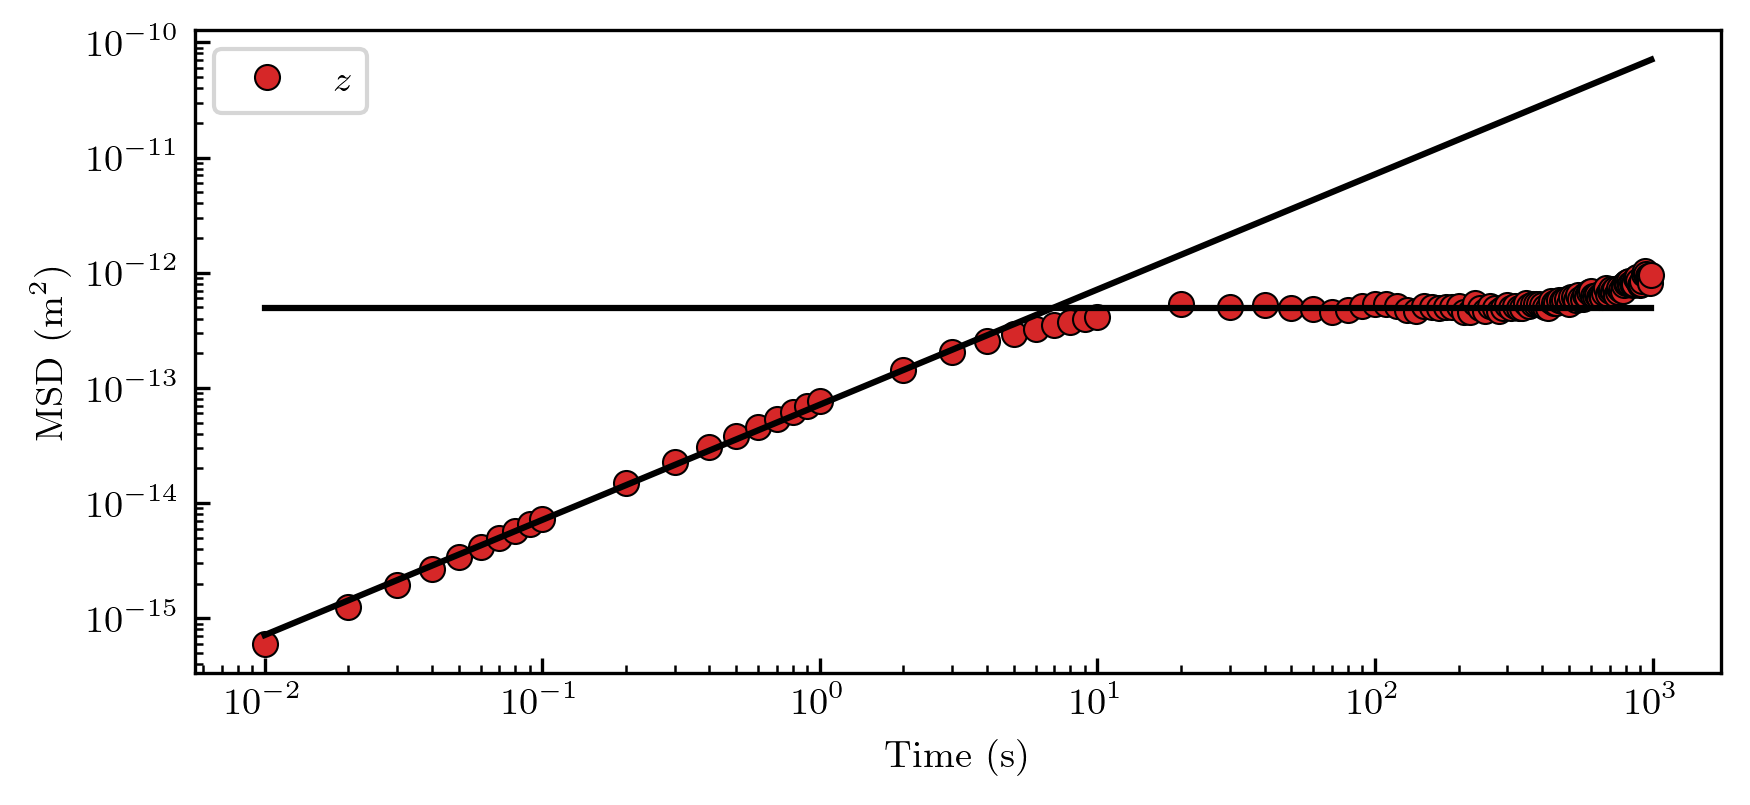

Measured equilibrium time = 6.9254346943592235 s
So dedrift time = 25 times the previous time = 173.1358673589806 s = 17313.586735898058 points


In [438]:
step = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 100000, 1000),
    )
)
tttt = step / fps

msdz = co.moment(2, z, step, retrieve_mean = False)

# =======
# Compute 
# =======

# Input times in s
start_short = 0 
stop_short = 0.1
start_long = 50
stop_long = 100

f_short = lambda x, a, b: a*x + (2*b)**2
popt_short, _ = curve_fit(
    f_short, 
    tttt[(tttt >= start_short) & (tttt <= stop_short)], msdz[(tttt >= start_short) & (tttt <= stop_short)], 
    p0=[2 * 0.2 * 4e-21 / (6*np.pi*eta_m*r), 0.], 
)
coef = popt_short[0]
plateau = np.nanmean(msdz[(tttt >= start_long) & (tttt <= stop_long)])

tau_eq = plateau / coef

# ====
# Plot
# ====

fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 7 / 2.54), dpi=300)

ax.plot(
    tttt, msdz, 
    'o', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=0.5, 
    label="$z$", 
)
ax.plot(tttt, f_short(tttt, *popt_short), '-k')
ax.plot(tttt, np.ones(len(tttt)) * plateau, '-k')

ax.legend()

ax.set(
    xscale='log', 
    yscale='log', 
    xlabel="Time (s)", 
    ylabel="MSD $\mathrm{(m^2)}$", 
)

plt.tight_layout()
plt.show()


# =====
# Print
# =====
print("Measured equilibrium time = {} s".format(tau_eq))
to_be_chosen = tau_eq*25
print("So dedrift time = 25 times the previous time = {0} s = {1} points".format(to_be_chosen, to_be_chosen*fps))

In [439]:
# fig.savefig()

In [440]:
print("Measured equilibrium time = {} s".format(tau_eq))
print("So dedrift time = 25 times the previous time = {0} s = {1} points".format(to_be_chosen, to_be_chosen*fps))

Measured equilibrium time = 6.9254346943592235 s
So dedrift time = 25 times the previous time = 173.1358673589806 s = 17313.586735898058 points


In [444]:
# Choose the dedrift nb of points and dedrift the trajectory

#####

###

#

nb_points_to_dedrift = 17000

#

###

#####

z_dedrift = z - co.movmin(z, nb_points_to_dedrift)
# z_dedrift = z - movmean(z, nb_points_to_dedrift)
# z_dedrift = z_dedrift - np.min(z_dedrift)
print("Time for dedrift = {} s".format(nb_points_to_dedrift / fps))

Time for dedrift = 170.0 s


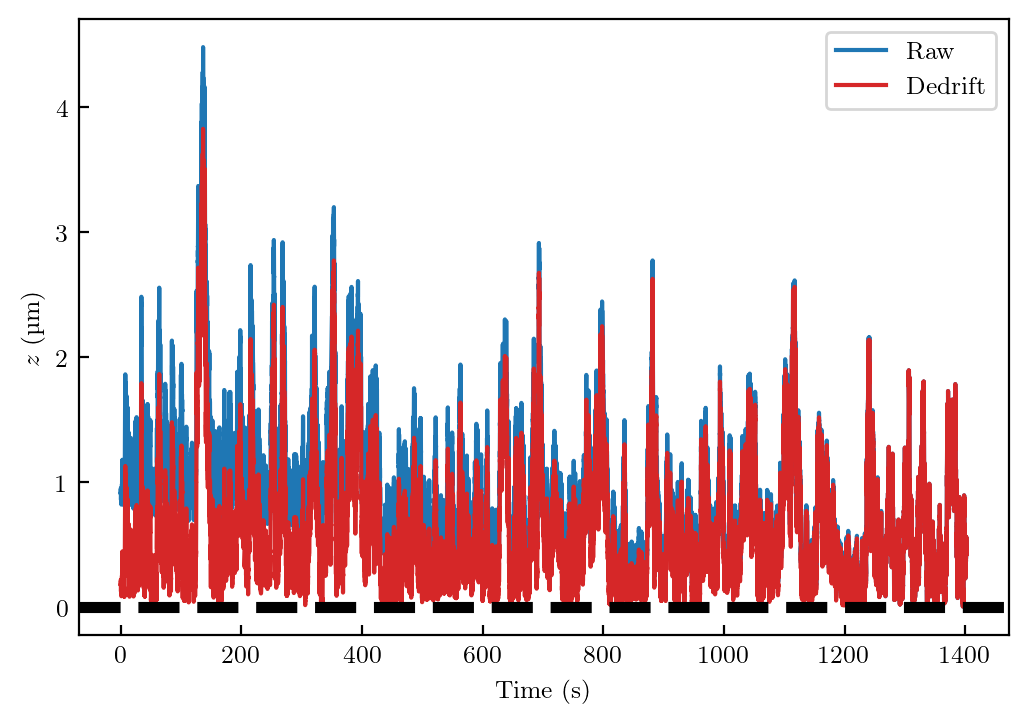

In [445]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(time, (z - np.min(z)) * 1e6, '-', c='tab:blue', label="Raw")
ax.plot(time, z_dedrift * 1e6, '-', c='tab:red', label="Dedrift")
ax.axhline(y=0, ls='--', color='k', linewidth=4)

ax.set_xlabel("Time (s)")
ax.set_ylabel("$z$ (µm)")

ax.legend()

plt.show()

In [446]:
# Save data

tosave['x'] = np.copy(x)
tosave['y'] = np.copy(y)
tosave['z'] = np.copy(z)

tosave["nb_points_to_dedrift"] = nb_points_to_dedrift
tosave["z_dedrift"] = np.copy(z_dedrift)

In [447]:
# filename

In [448]:
# savetraj = {
#     'x': xraw, 
#     'y': yraw,
#     'z': zraw, 
#     'fps': fps, 
# }

# savemat('traj_PRR_SI_rp_1p516_np_1p597_fps_60_calib_0p0513.mat', savetraj, appendmat=False)

# fig, ax = plt.subplots(1, 1, figsize=(7/2.54,5/2.54))

# ax.plot(time, (z - np.min(z)) * 1e6, '-', c='tab:red', linewidth=1)
# ax.axhline(y=0, ls='--', color='k', linewidth=1)

# ax.set_xlabel("$t$ (s)")
# ax.set_ylabel("$z$ (µm)")

# plt.tight_layout()
# plt.show()

# fig.savefig('fig_pres_z_raw_traj_2_20231114.pdf')

In [449]:
# savetraj['z']

# __Analysis of the Trajectory__ 

First, obversables are computed and basic properties are estimated (mean diffusion coefficient, noise levels, etc.). Some of the observables are also fitted independently to check that every observable are correct. 

Second, the multifitting procedure is performed.

# MSD

In [450]:
def correlations(x, t):
    res = np.zeros(len(t))
    std = np.zeros(len(t))
    for i, j in enumerate(t):
        #x_tau = x[j:] - np.mean(x[j:])
        #x_zer = x[0:-j] - np.mean(x[0:-j])
        #res[i] = np.nanmean((x_tau - x_zer)**n)
        dx = x[j:] - x[:-j]
        distribution = dx[j:] * dx[:-j]
        res[i] = np.nanmean(distribution)
    return res

In [451]:
delta_frame_nb = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 70000, 1000),
    )
)

delta_time_MSD = time[delta_frame_nb]

MSD_x, std_MSD_x = co.moment(2, x, delta_frame_nb, return_std = True, retrieve_mean = True) # Function in wrapper
MSD_y, std_MSD_y = co.moment(2, y, delta_frame_nb, return_std = True, retrieve_mean = True)
MSD_z, std_MSD_z = co.moment(2, z_dedrift, delta_frame_nb, return_std = True, retrieve_mean = True)


corr_x = correlations(x, delta_frame_nb)
corr_y = correlations(y, delta_frame_nb)
corr_z = correlations(z, delta_frame_nb)


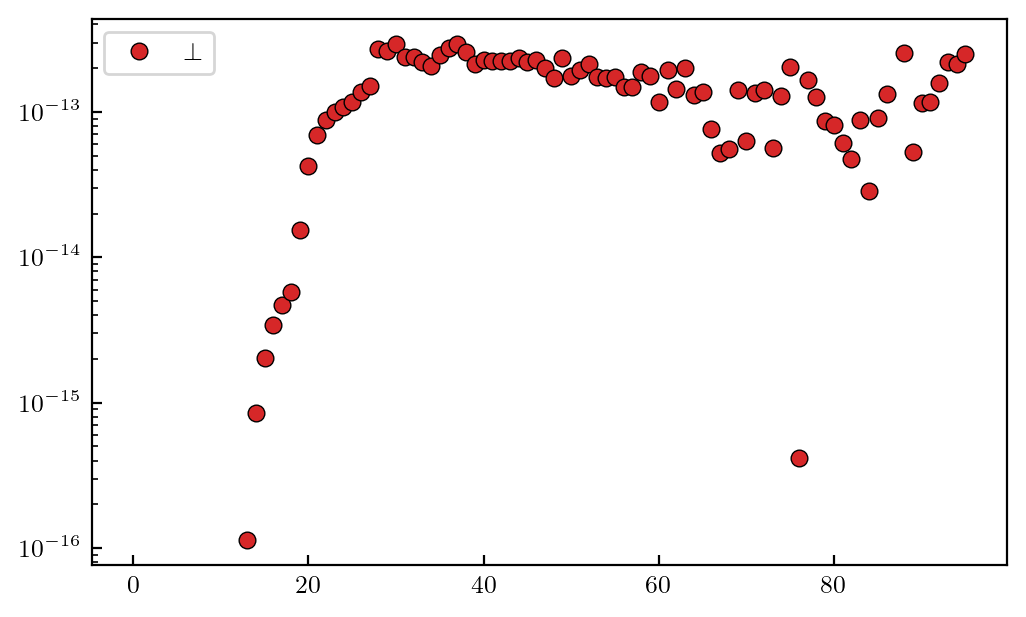

In [453]:
fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 9 / 2.54))

# ax.plot(corr_x, 'o', markerfacecolor=colors[1], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"$\parallel$")
ax.plot(-corr_z, 'o', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"$\perp$")

# ax.plot(delta_time_MSD, MSD_z, 's', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$z$")

# ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()

plt.show()

In [454]:
# cond = np.where(abs(corr_z) > MSD_z / 10)[0]
sta = 0
sto = 10 # cond[0]
corr_x = corr_x[sta:sto]
corr_y = corr_y[sta:sto]
corr_z = corr_z[sta:sto]
corr_x = corr_x[:]
corr_y = corr_y[:]
corr_z = corr_z[:]
MSD_x_bis, MSD_y_bis, MSD_z_bis = np.copy(MSD_x), np.copy(MSD_y), np.copy(MSD_z)
MSD_x_bis[:len(corr_x)] = MSD_x[:len(corr_x)] + 2 * corr_x
MSD_y_bis[:len(corr_y)] = MSD_y[:len(corr_y)] + 2 * corr_y
MSD_z_bis[:len(corr_z)] = MSD_z[:len(corr_z)] + 2 * corr_z

sta, sto = 0, 20
MSD_x_ter, MSD_y_ter, MSD_z_ter = np.copy(MSD_x), np.copy(MSD_y), np.copy(MSD_z)
tau_e = 2e-3
R = tau_e / 6 / delta_time_MSD
MSD_x_ter[sta:sto] = MSD_x[sta:sto] / (1 - 2 * R[sta:sto])
MSD_y_ter[sta:sto] = MSD_y[sta:sto] / (1 - 2 * R[sta:sto])
MSD_z_ter[sta:sto] = MSD_z[sta:sto] / (1 - 2 * R[sta:sto])




MSD_para = (MSD_x + MSD_y) / 2
std_MSD_para = (std_MSD_x + std_MSD_y) / 2
MSD_perp = np.copy(MSD_z)
std_MSD_perp = np.copy(std_MSD_z)

MSD_para_bis = (MSD_x_bis + MSD_y_bis) / 2
# std_MSD_para_bis = (std_MSD_x_bis + std_MSD_y_bis) / 2
MSD_perp_bis = np.copy(MSD_z_bis)
# std_MSD_perp_bis = np.copy(std_MSD_z_bis)

MSD_para_ter = (MSD_x_ter + MSD_y_ter) / 2
# std_MSD_para_ter = (std_MSD_x_ter + std_MSD_y_ter) / 2
MSD_perp_ter = np.copy(MSD_z_ter)
# std_MSD_perp_ter = np.copy(std_MSD_z_ter)

In [455]:
# Fit the MSD 
# Short and long times

start_MSD_x = 0
stop_MSD_x = 10
start_MSD_z = 0
stop_MSD_z = 10
start_long_times = 150 # s
stop_long_times = 200

# Long times

plateau_MSD_perp = np.nanmean(MSD_z[(delta_time_MSD > start_long_times) & (delta_time_MSD < stop_long_times)])

# Short times

def MSD_th(t, reduced_D, noiselevel, tau_e=0):
    return 2 * reduced_D * (1 - tau_e/3/t) * D0 * t + (2 * noiselevel) ** 2

def fit_MSD(dt, MSD, start, stop, p0=[0.5, 0]):
    popt, _ = curve_fit(
        MSD_th, 
        delta_time_MSD[start:stop], 
        MSD[start:stop], 
        p0 = p0, 
    )
    return popt

def fit_MSDs(dt, MSD_x, MSD_y, MSD_z, start_MSD_x, stop_MSD_x, start_MSD_z, stop_MSD_z, p0x=[0.5,0], p0z=[0.25,0]):
    popt_MSD_x = fit_MSD(dt, MSD_x, start_MSD_x, stop_MSD_x, p0=p0x)
    popt_MSD_y = fit_MSD(dt, MSD_y, start_MSD_x, stop_MSD_x, p0=p0x)
    popt_MSD_z = fit_MSD(dt, MSD_z, start_MSD_z, stop_MSD_z, p0=p0z)
    mean_D_para_from_MSD = (popt_MSD_x[0] + popt_MSD_y[0]) / 2
    mean_D_perp_from_MSD = popt_MSD_z[0]
    noise_level_para_from_MSD = (popt_MSD_x[1] + popt_MSD_y[1]) / 2
    noise_level_perp_from_MSD = popt_MSD_z[1]
    return popt_MSD_x, popt_MSD_y, popt_MSD_z, mean_D_para_from_MSD, mean_D_perp_from_MSD, noise_level_para_from_MSD, noise_level_perp_from_MSD

In [456]:
res = fit_MSDs(delta_time_MSD, MSD_x, MSD_y, MSD_z, start_MSD_x, stop_MSD_x, start_MSD_z, stop_MSD_z, p0x=[0.5,0], p0z=[0.25,0])
popt_MSD_x, popt_MSD_y, popt_MSD_z, mean_D_para_from_MSD, mean_D_perp_from_MSD, noise_level_para_from_MSD, noise_level_perp_from_MSD = res

/tmp/ipykernel_10113/1995885756.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


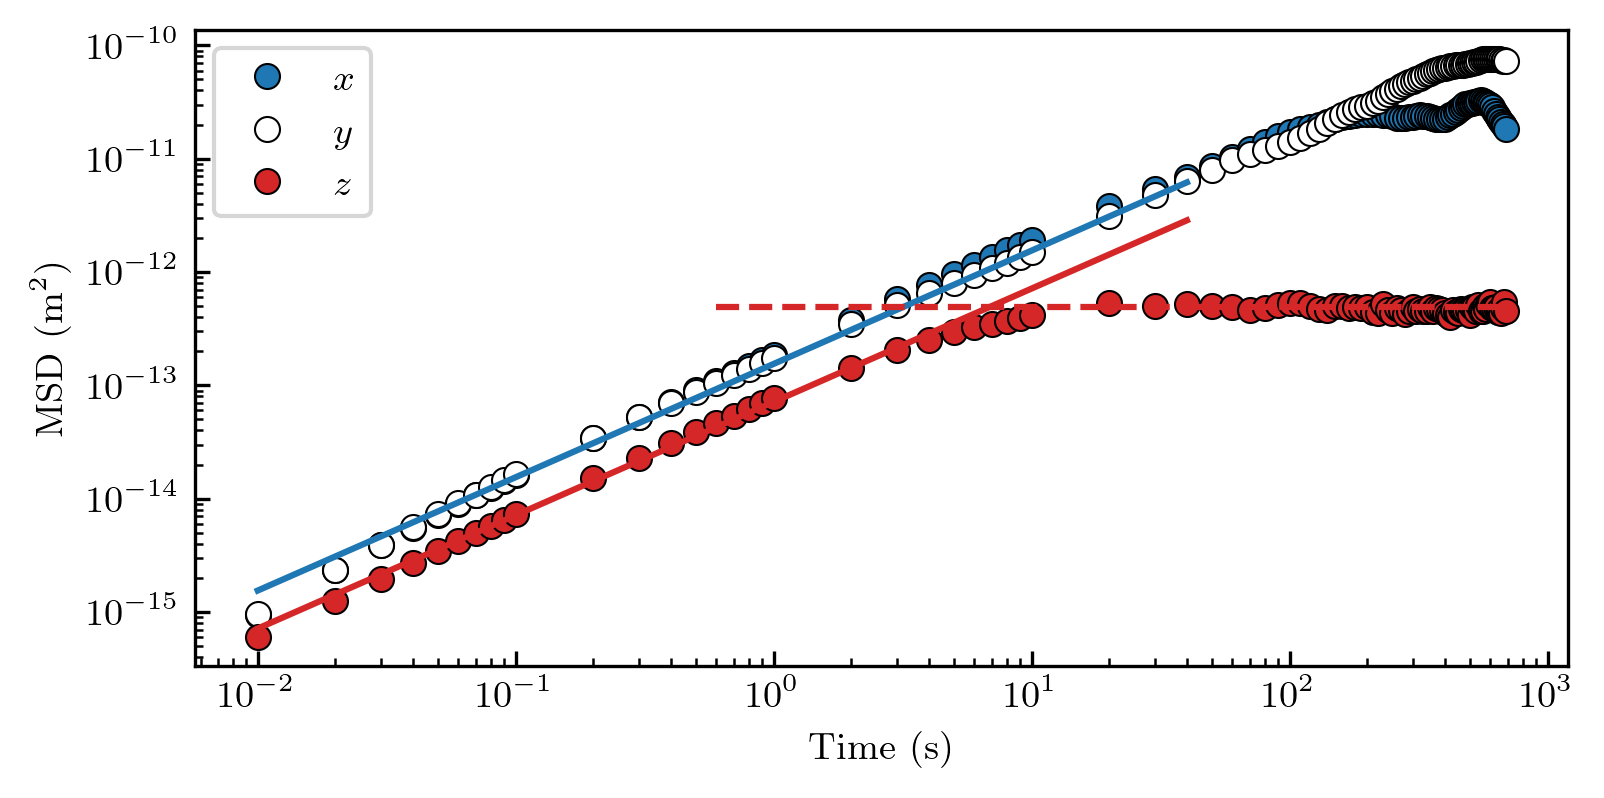

The measured mean diffusion coefficients are:
   0.557D0 in the parallel direction
   0.256D0 in the normal direction
FYI, D0 = 1.397e-13 m^2/s
The measured noise levels are:
   -0.000 nm in the parallel direction
   0.000 nm in the normal direction


In [457]:
fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 7 / 2.54), dpi=300)

ax.plot(delta_time_MSD, MSD_x, 'o', markerfacecolor='tab:blue', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$x$")
ax.plot(delta_time_MSD, MSD_y, 'o', markerfacecolor='w', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$y$")
ax.plot(delta_time_MSD, MSD_z, 'o', markerfacecolor='tab:red', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$z$")

ax.plot(delta_time_MSD[delta_time_MSD < 50], MSD_th(delta_time_MSD[delta_time_MSD < 50], *popt_MSD_x), ls='-', c='tab:blue', linewidth=1.5)
ax.plot(delta_time_MSD[delta_time_MSD < 50], MSD_th(delta_time_MSD[delta_time_MSD < 50], *popt_MSD_z), ls='-', c='tab:red', linewidth=1.5)
# ax.plot(delta_time_MSD[delta_time_MSD > 0.5], plateau_MSD_para * np.ones(len(delta_time_MSD[delta_time_MSD > 0.5])), '--', c='tab:blue', linewidth=1.5)
ax.plot(delta_time_MSD[delta_time_MSD > 0.5], plateau_MSD_perp * np.ones(len(delta_time_MSD[delta_time_MSD > 0.5])), '--', c='tab:red', linewidth=1.5)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Time (s)")
ax.set_ylabel(r"MSD $\mathrm{(m^2)}$")

ax.legend()

plt.show()

print("The measured mean diffusion coefficients are:")
print("   {0:.3f}D0 in the parallel direction".format(mean_D_para_from_MSD))
print("   {0:.3f}D0 in the normal direction".format(mean_D_perp_from_MSD))
print("FYI, D0 = {0:.3e} m^2/s".format(D0))
print("The measured noise levels are:")
print("   {0:.3f} nm in the parallel direction".format(noise_level_para_from_MSD * 1e9))
print("   {0:.3f} nm in the normal direction".format(noise_level_perp_from_MSD * 1e9))

In [458]:
res_bis = fit_MSDs(delta_time_MSD, MSD_x_bis, MSD_y_bis, MSD_z_bis, start_MSD_x, stop_MSD_x, start_MSD_z, stop_MSD_z, p0x=[0.5,0], p0z=[0.25,0])
popt_MSD_x_bis, popt_MSD_y_bis, popt_MSD_z_bis, mean_D_para_from_MSD_bis, mean_D_perp_from_MSD_bis, noise_level_para_from_MSD_bis, noise_level_perp_from_MSD_bis = res_bis

/tmp/ipykernel_10113/1995885756.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


In [459]:
colors = sns.color_palette("Paired")[:]

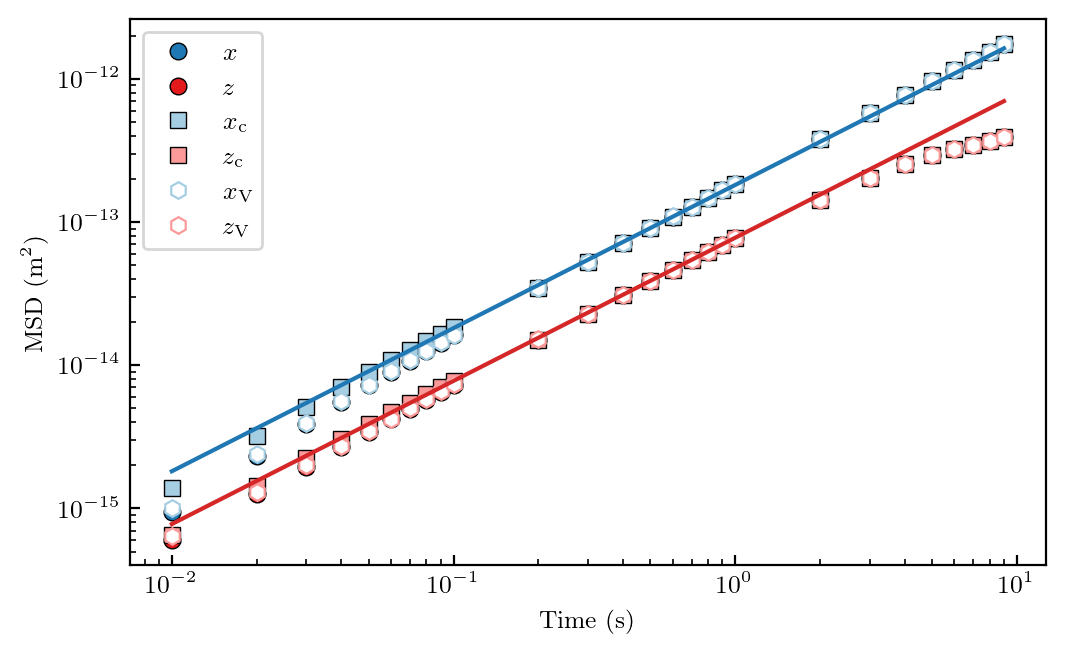

The measured mean diffusion coefficients are:
   0.557D0 in the parallel direction
   0.256D0 in the normal direction
FYI, D0 = 1.397e-13 m^2/s
The measured noise levels are:
   -0.000 nm in the parallel direction
   0.000 nm in the normal direction


In [460]:
# Compare with and without correlation corrections

fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 9 / 2.54))

tmin = 0
tmax = 10

cond = (delta_time_MSD < tmax) & (delta_time_MSD > tmin)

ax.plot(delta_time_MSD[cond], MSD_x[cond], 'o', markerfacecolor=colors[1], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$x$")
# ax.plot(delta_time_MSD, MSD_y, 'o', markerfacecolor='w', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$y$")
ax.plot(delta_time_MSD[cond], MSD_z[cond], 'o', markerfacecolor=colors[5], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$z$")

ax.plot(delta_time_MSD[cond], MSD_x_bis[cond], 's', mfc=colors[0], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"$x_\mathrm{c}$")
# ax.plot(delta_time_MSD, MSD_y, 'o', markerfacecolor='w', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$y$")
ax.plot(delta_time_MSD[cond], MSD_z_bis[cond], 's', mfc=colors[4], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"$z_\mathrm{c}$")

ax.plot(delta_time_MSD[cond], MSD_x_ter[cond], 'h', mfc='w', markersize=6, markeredgecolor=colors[0], markeredgewidth=0.8, label=r"$x_\mathrm{V}$")
# ax.plot(delta_time_MSD, MSD_y, 'o', markerfacecolor='w', markersize=6, markeredgecolor='k', markeredgewidth=0.5, label="$y$")
ax.plot(delta_time_MSD[cond], MSD_z_ter[cond], 'h', mfc='w', markersize=6, markeredgecolor=colors[4], markeredgewidth=0.8, label=r"$z_\mathrm{V}$")

ax.plot(delta_time_MSD[cond], MSD_th(delta_time_MSD[cond], *popt_MSD_x_bis), ls='-', c='tab:blue', linewidth=1.5)
ax.plot(delta_time_MSD[cond], MSD_th(delta_time_MSD[cond], *popt_MSD_z_bis), ls='-', c='tab:red', linewidth=1.5)
# ax.plot(delta_time_MSD[delta_time_MSD > 0.5], plateau_MSD_perp * np.ones(len(delta_time_MSD[delta_time_MSD > 0.5])), '--', c='tab:red', linewidth=1.5)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Time (s)")
ax.set_ylabel(r"MSD $\mathrm{(m^2)}$")

ax.legend()

plt.show()

print("The measured mean diffusion coefficients are:")
print("   {0:.3f}D0 in the parallel direction".format(mean_D_para_from_MSD))
print("   {0:.3f}D0 in the normal direction".format(mean_D_perp_from_MSD))
print("FYI, D0 = {0:.3e} m^2/s".format(D0))
print("The measured noise levels are:")
print("   {0:.3f} nm in the parallel direction".format(noise_level_para_from_MSD * 1e9))
print("   {0:.3f} nm in the normal direction".format(noise_level_perp_from_MSD * 1e9))

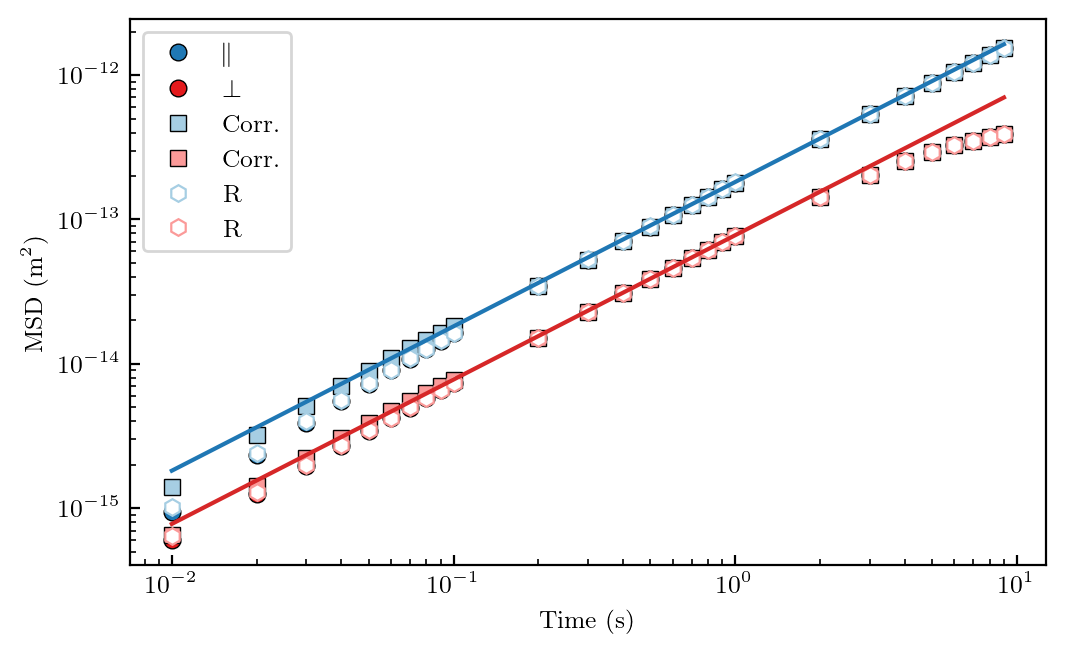

In [461]:
fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 9 / 2.54))

tmin = 0
tmax = 10

cond = (delta_time_MSD < tmax) & (delta_time_MSD > tmin)

ax.plot(delta_time_MSD[cond], MSD_para[cond], 'o', markerfacecolor=colors[1], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"$\parallel$")
ax.plot(delta_time_MSD[cond], MSD_perp[cond], 'o', markerfacecolor=colors[5], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"$\perp$")

ax.plot(delta_time_MSD[cond], MSD_para_bis[cond], 's', mfc=colors[0], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"Corr.")
ax.plot(delta_time_MSD[cond], MSD_perp_bis[cond], 's', mfc=colors[4], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"Corr.")

ax.plot(delta_time_MSD[cond], MSD_para_ter[cond], 'h', mfc='w', markersize=6, markeredgecolor=colors[0], markeredgewidth=0.8, label=r"R")
ax.plot(delta_time_MSD[cond], MSD_perp_ter[cond], 'h', mfc='w', markersize=6, markeredgecolor=colors[4], markeredgewidth=0.8, label=r"R")

ax.plot(delta_time_MSD[cond], MSD_th(delta_time_MSD[cond], *popt_MSD_x_bis), ls='-', c='tab:blue', linewidth=1.5)
ax.plot(delta_time_MSD[cond], MSD_th(delta_time_MSD[cond], *popt_MSD_z_bis), ls='-', c='tab:red', linewidth=1.5)
# ax.plot(delta_time_MSD[delta_time_MSD > 0.5], plateau_MSD_perp * np.ones(len(delta_time_MSD[delta_time_MSD > 0.5])), '--', c='tab:red', linewidth=1.5)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Time (s)")
ax.set_ylabel(r"MSD $\mathrm{(m^2)}$")

ax.legend()

plt.show()

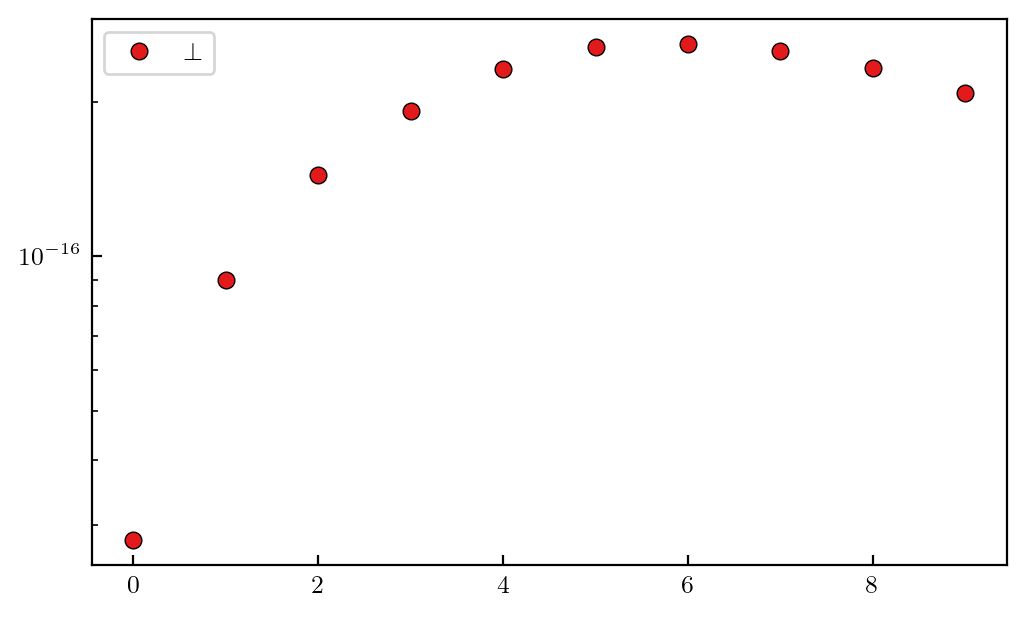

In [463]:
fig, ax = plt.subplots(1, 1, figsize = (15 / 2.54, 9 / 2.54))

# ax.plot(corr_x, 'o', markerfacecolor=colors[1], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"$\parallel$")
ax.plot(corr_z, 'o', markerfacecolor=colors[5], markersize=6, markeredgecolor='k', markeredgewidth=0.5, label=r"$\perp$")

# ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()

plt.show()

# Save

In [464]:
tosave['delta_frame_nb'] = np.copy(delta_frame_nb)
tosave['delta_time_MSD'] = np.copy(delta_time_MSD)

tosave['MSD_para'] = np.copy(MSD_para)
tosave['MSD_perp'] = np.copy(MSD_perp)
tosave['MSD_para_R'] = np.copy(MSD_para_ter)
tosave['MSD_perp_R'] = np.copy(MSD_perp_ter)
tosave['MSD_para_c'] = np.copy(MSD_para_bis)
tosave['MSD_perp_c'] = np.copy(MSD_perp_bis)

tosave['mean_D_para_from_MSD'] = mean_D_para_from_MSD
tosave['noise_level_para_from_MSD'] = noise_level_para_from_MSD
tosave['mean_D_perp_from_MSD'] = mean_D_perp_from_MSD
tosave['noise_level_perp_from_MSD'] = noise_level_perp_from_MSD

tosave['mean_D_para_from_MSD_c'] = mean_D_para_from_MSD_bis
tosave['noise_level_para_from_MSD_c'] = noise_level_para_from_MSD_bis
tosave['mean_D_perp_from_MSD_c'] = mean_D_perp_from_MSD_bis
tosave['noise_level_perp_from_MSD_c'] = noise_level_perp_from_MSD_bis

In [465]:
directory

'../../analysis_PS_GNP_janus/data/20240909_PS_fps100_without_vids_MCL/7/traj_rp_1p4649_np_1p5875_vid_7.mat'

In [466]:
# savemat('study_MSD_not_linear_exp_20240909_4.mat', tosave)

# Local Diffusivity

In [467]:
# Plot diffusivity for sub-sample trajectories
# ie
# D local with n dt with n > 1

In [489]:
nsub = 1
dtsub = nsub / fps
all_orders = True

In [490]:
# Domain to plot the diffusion profile
z_min_force = 10e-9
z_max_force = 2e-6
N_bins_force = 30 

In [491]:
xsub, ysub, zsub = x[::nsub], y[::nsub], z_dedrift[::nsub]

pos = np.ones((len(xsub), 3))

pos[:, 0] = xsub
pos[:, 1] = ysub
pos[:, 2] = zsub

In [492]:
if all_orders:
    
    Dx1, Dy1, Dz1, z_D1 = Compute_diffusion(pos, dtsub, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=1, method="Vestergaard")
    Dx2, Dy2, Dz2, z_D2 = Compute_diffusion(pos, dtsub, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=2, method="Vestergaard")
    Dx3, Dy3, Dz3, z_D3 = Compute_diffusion(pos, dtsub, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=3, method="Vestergaard")
    Dx4, Dy4, Dz4, z_D4 = Compute_diffusion(pos, dtsub, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=4, method="Vestergaard")
    # Dx5, Dy5, Dz5, z_D5, err_Dz5 = Compute_diffusion(pos, dtsub, z_min=z_min_force, z_max=z_max_force, N=N_bins_force, ordre=5, method="Vestergaard")
    
    D_para_z1 = (Dx1 + Dy1) / 2 
    D_para_z2 = (Dx2 + Dy2) / 2 
    D_para_z3 = (Dx3 + Dy3) / 2 
    D_para_z4 = (Dx4 + Dy4) / 2 
    # D_para_z5 = (Dx5 + Dy5) / 2 

    D_perp_z1 = Dz1 
    D_perp_z2 = Dz2 
    D_perp_z3 = Dz3 
    D_perp_z4 = Dz4 
    # D_perp_z5 = Dz5 

In [493]:
def Dz_z(z, b=0, nl=0):
    z = z + b
    res = (6 * z * z + 2 * r * z) / (6 * z * z + 9 * r * z + 2 * r * r)
    res += nl
    return res

def Dx_z(z, b=0, nl=0):
    z = z + b 
    res = 1 - 9/16 * (r / (z + r)) + 1/8 * (r / (z + r)) ** 3 - 45/256 * (r / (z + r)) ** 4 - 1/16 * (r / (z + r)) ** 5
    res += nl
    return res

In [494]:
def min_arrays(t1, t2):
    if t1[0] < t2[0]:
        return t1
    return t2

def max_arrays(t1, t2):
    if t1[0] < t2[0]:
        return t2
    return t1

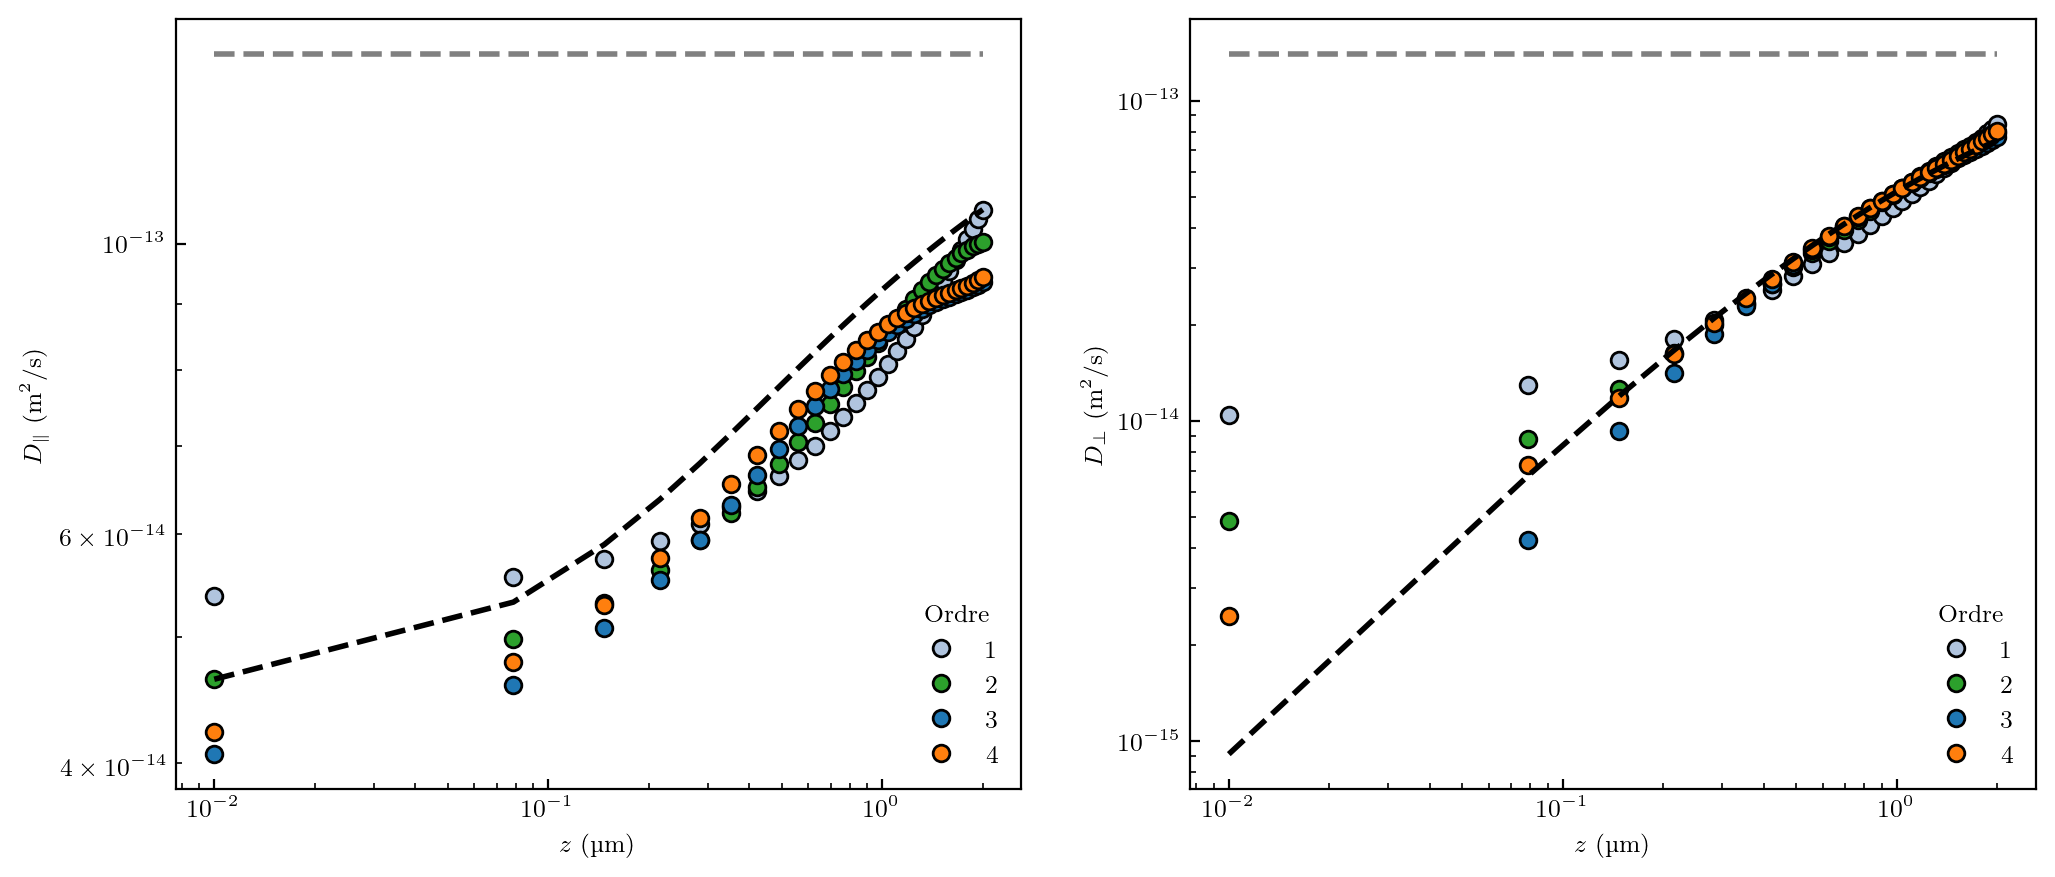

In [495]:
if all_orders:

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5))

    colors = ['lightsteelblue', 'tab:green', 'tab:blue', 'tab:orange', 'tab:red']

    ax1.plot(z_D1 * 1e6, D_para_z1, 'o', color=colors[0], label='1')
    ax1.plot(z_D2 * 1e6, D_para_z2, 'o', color=colors[1], label='2')
    ax1.plot(z_D3 * 1e6, D_para_z3, 'o', color=colors[2], label='3')
    ax1.plot(z_D4 * 1e6, D_para_z4, 'o', color=colors[3], label='4')
    # ax1.plot(z_D5 * 1e6, D_para_z5, 'o', color=colors[4], label='5')
    ax1.plot(z_D1 * 1e6, D0 * Dx_z(z_D1, 0, nl=0), ls='--', c='k', linewidth=2)
    ax1.plot(z_D1 * 1e6, D0 * np.ones(len(z_D1)), ls='--', c='gray', linewidth=2)
    # ax1.plot(r / z_D1 , - (D0 * Dx_z(z_D1, 0, nl=0) - D_para_z3) / D0 + 1, marker='o', c='k')
    # ax1.plot(r / z_D1, 3/8 * r / z_D1, '-.')

    # ax1.fill_between(
    #     z_D1 * 1e6, min_arrays(Dx1, Dy1), max_arrays(Dx1, Dy1), 
    #     alpha = 0.2, color=colors[0],
    # )
    # ax1.fill_between(
    #     z_D2 * 1e6, min_arrays(Dx2, Dy2), max_arrays(Dx2, Dy2), 
    #     alpha = 0.2, color=colors[1],
    # )
    # ax1.fill_between(
    #     z_D3 * 1e6, min_arrays(Dx3, Dy3), max_arrays(Dx3, Dy3), 
    #     alpha = 0.2, color=colors[2],
    # )
    # ax1.fill_between(
    #     z_D4 * 1e6, min_arrays(Dx4, Dy4), max_arrays(Dx4, Dy4), 
    #     alpha = 0.2, color=colors[3],
    # )
    # # ax1.fill_between(
    # #     z_D5 * 1e6, min_arrays(Dx5, Dy5), max_arrays(Dx5, Dy5), 
    # #     alpha = 0.2, color=colors[4],
    # # )

    ax1.legend(frameon=False, title='Ordre')
    
    ax1.set(
        xlabel="$z$ (µm)", 
        ylabel="$D_\parallel$ ($\mathrm{m^2/s}$)", 
        xscale='log', 
        yscale='log', 
    )

    ax2.plot(z_D1 * 1e6, D_perp_z1, 'o', color=colors[0], label='1')
    ax2.plot(z_D2 * 1e6, D_perp_z2 - 0.02 * D0 * 0, 'o', color=colors[1], label='2')
    ax2.plot(z_D3 * 1e6, D_perp_z3, 'o', color=colors[2], label='3')
    ax2.plot(z_D4 * 1e6, D_perp_z4, 'o', color=colors[3], label='4')
    # ax2.plot(z_D5 * 1e6, D_perp_z5, 'o', color=colors[4], label='5')
    ax2.plot(z_D1 * 1e6, D0 * Dz_z(z_D1, 0, nl=0), ls='--', c='k', linewidth=2)
    ax2.plot(z_D1 * 1e6, D0 * np.ones(len(z_D1)), ls='--', c='gray', linewidth=2)

    ax2.legend(frameon=False, title='Ordre')
    
    ax2.set(
        xlabel="$z$ (µm)", 
        ylabel="$D_\perp$ ($\mathrm{m^2/s}$)", 
        xscale='log', 
        yscale='log', 
    )

    plt.show()